here the files are merged to create a workable dataset
exported to csv and not succesfully yet to shp

In [73]:
#import data and packages
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
from functions import *
%matplotlib inline



In [74]:
#import anlagedata
d='DATA/Sacken/Anlagendaten.xlsx'
data=pd.read_excel(d)
data=data.dropna(how='any', subset= ['Longitude'])

#create geometry from coordinates 
#only studying the geometry of the shp made possible to intepret this file correctly
gdf=geopandas.GeoDataFrame(data, geometry=geopandas.points_from_xy((data['Longitude']), data['KOORDX(GK M31)'], crs='EPSG:31258'))

#take onlty <50
anlage=gdf[gdf.EGW<51]
anlage.dropna(how='all',inplace=True)


C:\Users\fabrizio\anaconda3\envs\geo\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [75]:
#clean data here

In [76]:
#import dataset with wrong coords but technical features
d = 'C:/Users/fabrizio/Documents/repos/MSC/DATA/Sacken/raw_data.xlsx'
df=pd.read_excel(d, sheet_name='Rohdaten ARA 500 EW')
df=df[df.EW60<51]


In [77]:
#confront for number of items
print(len(anlage)) #only contanins <50
print(len(df))#raw data <50

#df is 12 elements longer

2514
2526


In [78]:
#all anlage are in df 
len(anlage[anlage.Bundesnummer.isin(df.BUNDESNUMMER)])

2514

In [79]:
#11 are not in anlage. 1 is probably an NA
#means can't get their position right now
not_in=df[~df.BUNDESNUMMER.isin(anlage.Bundesnummer)]
len(not_in)

11

In [80]:
#prepare for megre
anlage=anlage.astype({'Bundesnummer':'int'})
df.rename(columns={'BUNDESNUMMER':'Bundesnummer'}, inplace=True)


In [81]:
#merge
merged=pd.merge(df, anlage, on='Bundesnummer')
merged.head()
merged.dropna(subset=['Longitude','KOORDX(GK M31)_y'],inplace=True)


In [82]:
#get a geodf
gdf=geopandas.GeoDataFrame(merged, geometry=geopandas.points_from_xy((merged['Longitude']), merged['KOORDX(GK M31)_y'], crs='EPSG:31258'))


In [83]:
#get basemap
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
austria=world[world['name']=='Austria']


In [84]:
#change points coords to basemap
gdf.to_crs(epsg=4326,inplace=True)


<AxesSubplot:>

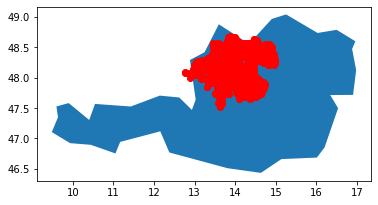

In [85]:
#plot them together
gdf.plot(color='red', ax=austria.plot())


In [86]:
#drop columns with <80% real data, not NA.
gdf=gdf[gdf.columns[gdf.isnull().mean()<0.8]]

#drop unused geodata
gdf=gdf.drop(columns=['KOORDX(GK M31)_y', 'Latitude','KOORDY(GK M31)_y','Longitude','GRUPPE', 'FABRIKATTYPE','ABLEITUNG IN','KOORDX(GK M31)_x', 'KOORDY(GK M31)_x'])


In [87]:
gdf.INBETRIEBNAHME=gdf.INBETRIEBNAHME.astype('str')

gdf.INBETRIEBNAHME=gdf.INBETRIEBNAHME.str.split('-').str[0]


gdf.INBETRIEBNAHME=gdf.INBETRIEBNAHME.str.split(',').str[0]

gdf=gdf[gdf.INBETRIEBNAHME!='<NULL>']

gdf.INBETRIEBNAHME=gdf.INBETRIEBNAHME.astype(int)


In [89]:
gdf.drop(columns=['Bundesnummer', 'ANLAGETEILNAME','Realisierungsstatus',
'KOORDINATEN GENAUIGKEIT', 'WASSERBUCH','dtKläranlage','Größenklasse',
'Kommunal/Industriell', 'EGW', 'BEZIRK'],inplace=True)

In [90]:
#most of anlage withoutnitrification are of type mechanic
gdf.groupby(['NITRIFIZIERUNG','Verfahren']).count()
#are anlage before regulation not nitrifying ?
gdf['before_reg']=gdf.INBETRIEBNAHME<1990
gdf.groupby(['NITRIFIZIERUNG','before_reg']).count()

#yes they are

ANLAGENAME  EW60  INBETRIEBNAHME  \
NITRIFIZIERUNG before_reg                                     
j              False             2119  2119            2119   
               True                36    36              36   
n              False               47    47              47   
               True               320   320             320   

                           VERFAHRENSART BIOLOGIE  REINIGUNG MECHANISCH  \
NITRIFIZIERUNG before_reg                                                 
j              False                         2119                  2119   
               True                            36                    36   
n              False                           47                    47   
               True                           320                   320   

                           C-ENTFERNUNG  N-ENTFERNUNG  P-ENTFERNUNG  Tonne TM  \
NITRIFIZIERUNG before_reg                                                       
j              False               2119          2119          2119      2119   
               True                  36            36            36        36   
n              False                 47            47            47        47   
               True                 320           320           320       320   

                           Verfahren   Typ  geometry  
NITRIFIZIERUNG before_reg                             
j              False            2119  2119      2119  
               True               36    36        36  
n              False              47    47        47  
               True              320   320       320

In [98]:
#correct values
gdf.Verfahren=gdf.Verfahren.str.strip(' ')
gdf.Verfahren.value_counts()


Belebung      580
SBR           573
PF            540
mechanisch    310
SBR +         289
Sonstig       128
Belebung +     78
Filtration     24
Name: Verfahren, dtype: int64

In [99]:
gdf.to_csv('output/oebo.csv', index=False)

In [96]:
#cur down to avoid codec error from german language
#export=gdf[['Bundesnummer','geometry']]

#shp is still unreadble for QGIS
#export.to_file('output/onemore.shp')
